In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
import skew_line
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)
importlib.reload(skew_line)

<module 'skew_line' from '../src\\skew_line.py'>

D:/Data/bujo_sample\20190309_125151.jpg


c:\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Text angles is 0.0
Text line delta is 9
Wall time: 2.62 s


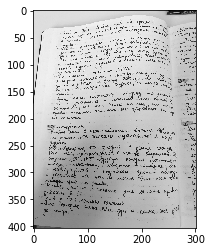

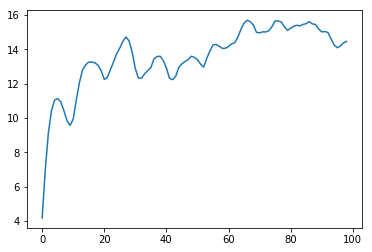

In [2]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)

src = skimage.io.imread(src_fname, as_grey=True)
text_angle = transform.get_text_angle(skimage.transform.rescale(src, scale=0.05))
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
srcr = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.5), -90.0-text_angle[0][0], resize=True)

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)

plt.figure()
plt.imshow(src3, cmap='gray')

plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

c:\anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 3.01 s


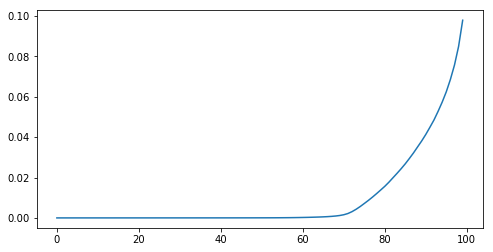

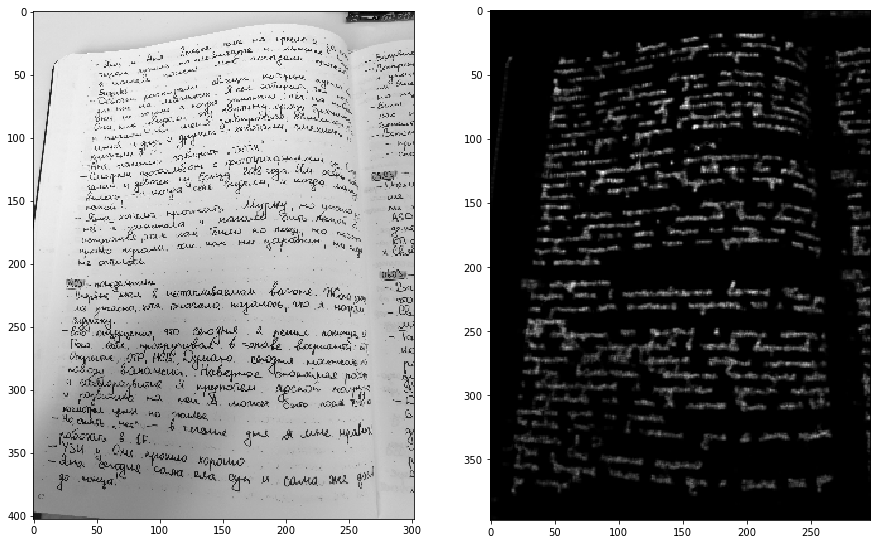

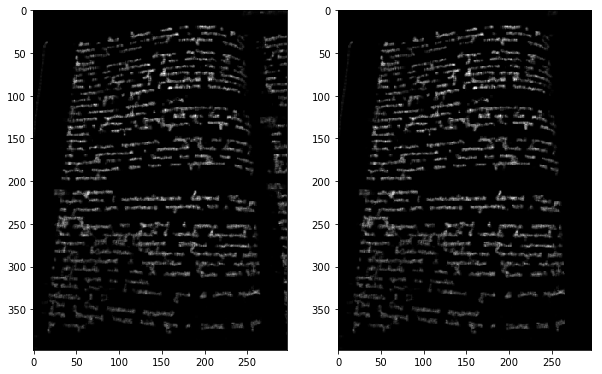

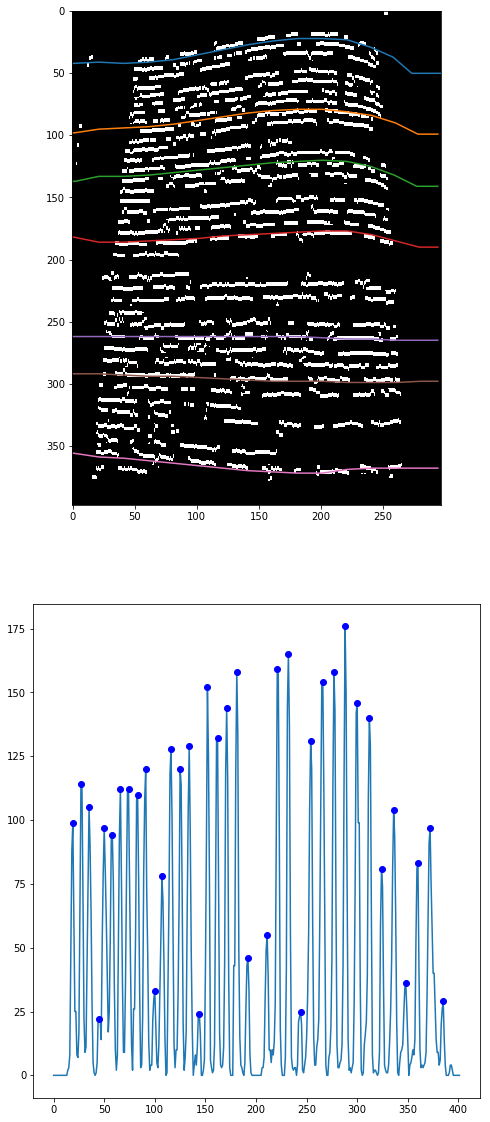

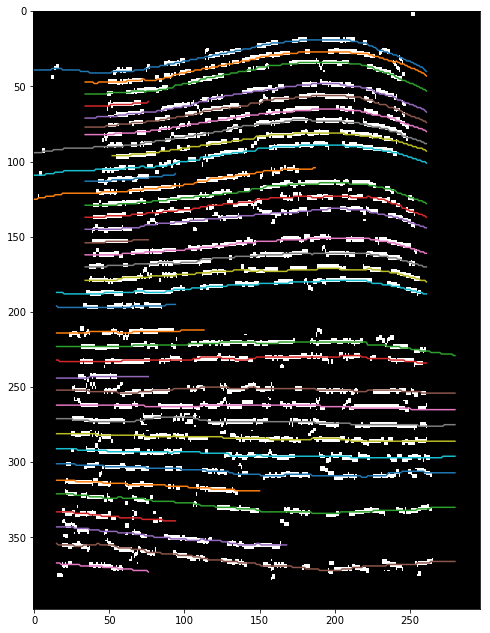

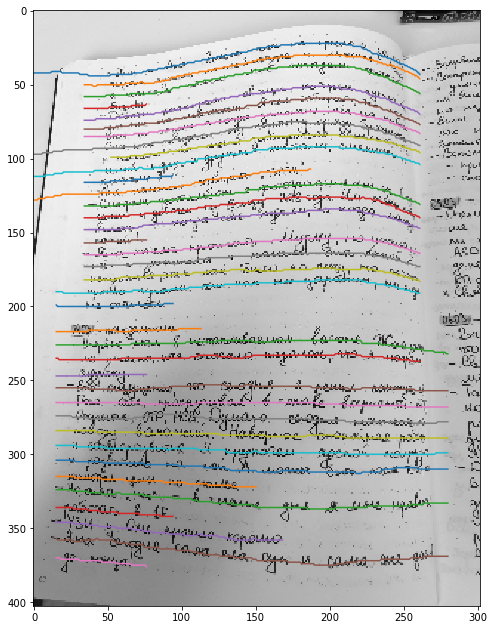

In [3]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)

src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

curves = skew_line.create_support_curves(src8, 20, (40, 50))

ires, imeta = skew_line.integrate_curves(src8, curves)
ids = skew_line.select_line_candidates(ires, text_line_delta//2, min_value=20, minmax_ratio=0.8)

all_curves = []
for i in ids:
    if len(imeta[i])>2:
        tmp_j, tmp_i = skew_line.interpolate_between_curves(np.arange(src8.shape[1]), 0, src8.shape[0]-1, imeta[i][0], imeta[i][1], imeta[i][2])
    else:
        tmp_j, tmp_i = skew_line.offset_curve(np.arange(src8.shape[1]), imeta[i][0], imeta[i][1])
    res_j, res_i = skew_line.optimize_curve(src8, tmp_j, tmp_i, offset=4, min_window=20)
    all_curves.append((res_j, res_i))

extracted_lines = transform.extract_lines_from_image(srcr, src7, all_curves, text_line_delta, 20, height_margin=0.5)

plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

plt.figure(figsize=(8,20))
plt.subplot(211)
plt.imshow(src8, cmap='gray')
for crv in curves:
    plt.plot(crv[:,1], crv[:,0])
    
plt.subplot(212)
plt.plot(ires)
for i in ids:
    plt.plot(i, ires[i], 'bo')
    
plt.figure(figsize=(8,20))
plt.imshow(src8, cmap='gray')
for crv_j, crv_i in all_curves:
    plt.plot(crv_j, crv_i)
    
plt.figure(figsize=(8,20))
plt.imshow(src3, cmap='gray')
for crv_j, crv_i in all_curves:
    plt.plot(crv_j, crv_i+text_line_delta//4+1)

In [5]:
def filter_stddev(src, filter_size):
    f_x1 = np.cumsum(np.cumsum(src, axis=0), axis=1)
    f_x2 = np.cumsum(np.cumsum(np.power(src, 2.0), axis=0), axis=1)
    if type(filter_size) is int:
        flt_w = filter_size
        flt_h = filter_size
    else:
        flt_w = filter_size[1]
        flt_h = filter_size[0]
    nsize = flt_w * flt_h
    d_x1 = f_x1[flt_h:,flt_w:]-f_x1[:-flt_h,flt_w:]-f_x1[flt_h:,:-flt_w]+f_x1[:-flt_h,:-flt_w]
    d_x2 = f_x2[flt_h:,flt_w:]-f_x2[:-flt_h,flt_w:]-f_x2[flt_h:,:-flt_w]+f_x2[:-flt_h,:-flt_w]
    return np.sqrt(np.maximum(0,(d_x2 - d_x1*d_x1/nsize))/nsize)

def create_regularization_vector(height, reg_lo, reg_hi, reg_center_pct):
    reg1 = np.abs(np.linspace(0, 1, height) - reg_center_pct)
    reg2 = np.minimum(1.0, reg1 / min(reg1[0], reg1[-1]))
    return np.power(1 - np.power(reg2, reg_hi), reg_lo)

def calculate_word_curve(curve_p, curve_j, curve_i, word_location, num_points=2):
    interp_l = np.linspace(word_location[0], word_location[1], num_points)
    res_j = np.interp(interp_l, curve_p, curve_j)
    res_i = np.interp(interp_l, curve_p, curve_i)
    return np.linspace(0, word_location[1]-word_location[0], num_points), res_j, res_i

def array_minmax(arr, i, window):
    if i <= 0:
        return np.max(arr[:window])
    if i >= len(arr)-1:
        return np.max(arr[max(len(arr)-window, 0):])
    i0 = max(i-window, 0)
    i1 = min(i+window, len(arr))
    return min(np.max(arr[i0:i]), np.max(arr[i:i1]))

def extract_words(src_line, crv_p, crv_j, crv_i, offsets,
                      sigma=(5, 15), cutoff_coef=0.8, cutoff_ratio=0.35, cutoff_offset=0.1,
                     filter_size=7, window=10,
                     reg_lo=3.0, reg_hi=2.0, word_num_points=2):
    src_flt = filter_stddev(src_line, filter_size)
    reg_center = -offsets[0] / (offsets[1] - offsets[0])
    reg_vector = create_regularization_vector(src_flt.shape[0], reg_lo, reg_hi, reg_center)
    src_fg = skimage.filters.gaussian(src_flt, sigma)
    rs = np.array([src_fg[:,i]*reg_vector for i in range(src_fg.shape[1])]).T
    rm = np.max(rs, axis=0)
    plt.figure()
    plt.plot(rm)
    mins0 = local_radon.get_local_minimas_1d(rm, 1, np.max(rm) * cutoff_coef)
    vmins0 = rm[mins0] - cutoff_offset * np.max(rm)
    vmaxs0 = [array_minmax(rm, i, window//2) for i in mins0]
    #vmaxs0 = scipy.ndimage.filters.maximum_filter1d(rm, window)[mins0]
    vcoefs = (vmaxs0 - vmins0) / np.maximum(1e-4, vmins0)
    mins1 = mins0[vcoefs > cutoff_ratio]
    mins = [0] + list(mins1) + [len(rm)-1]
    wrd_locs = list(zip(mins[:-1], mins[1:]))
    print(mins0)
    #print(vmins0)
    #print(vmaxs0)
    print(vcoefs)
    print(wrd_locs)
    if wrd_locs is None or len(wrd_locs)==0:
        return []
    res = []
    for (w0, w1) in wrd_locs:
        c0 = w0#int(np.floor(w0 * src_line.shape[1] / (src_line.shape[1] - filter_size)))
        c1 = w1 + filter_size - 1#int(np.ceil(w1 * src_line.shape[1] / (src_line.shape[1] - filter_size)))
        wrd_src = src_line[:, c0:c1]
        wrd_crv = calculate_word_curve(crv_p, crv_j, crv_i, (c0, c1), word_num_points)
        wrd_off = offsets
        res.append((wrd_src, wrd_crv, wrd_off))
    return res

[  37  132  200  268  367  427  553  729  855  911  947 1043 1105 1158 1227
 1301]
[  1.44833918e+02   1.46389037e+02   1.54397551e+02   2.20166290e+00
   2.23228193e+01   3.37623840e+01   5.09162214e+02   1.47256264e+02
   1.72811520e+01   6.72466104e-02   6.17973482e+00   9.02087315e-02
   2.37140464e+00   1.49930960e+01   1.16296711e+00   2.75817383e+02]
[(0, 37), (37, 132), (132, 200), (200, 268), (268, 367), (367, 427), (427, 553), (553, 729), (729, 855), (855, 947), (947, 1105), (1105, 1158), (1158, 1227), (1227, 1301), (1301, 1334)]
0.00279053781905
0.0910686017636
0.00712206991569
0.0643706869053
0.148231243307
0.0772072123094
0.125617196562
0.151271330375
0.145264489542


c:\anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.131768830456
0.174565533589
0.15009137104
0.158779178036
0.13183220406
0.0180336768652
Wall time: 3.03 s


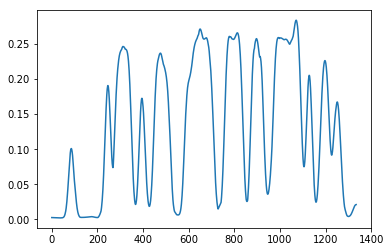

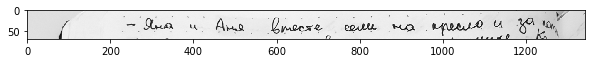

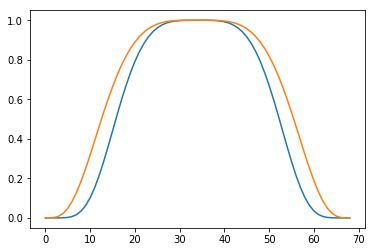

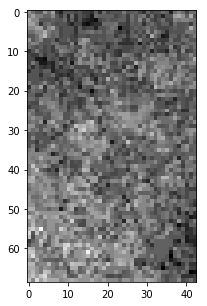

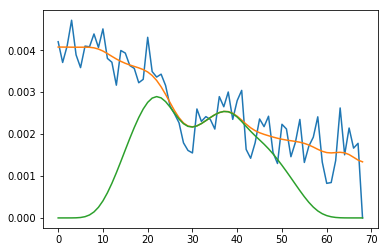

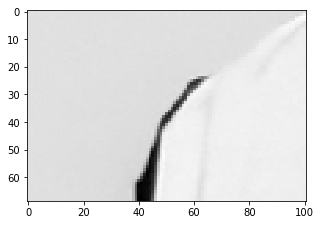

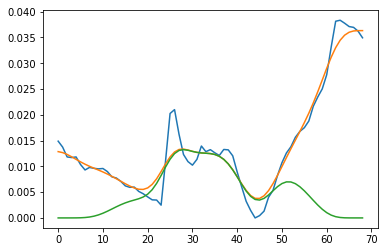

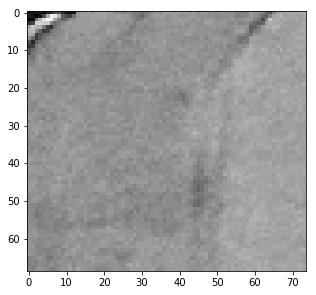

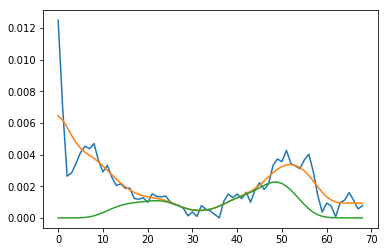

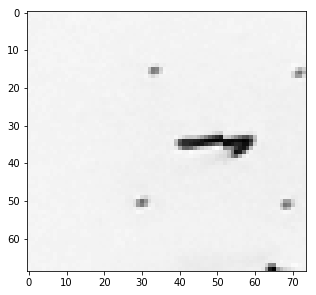

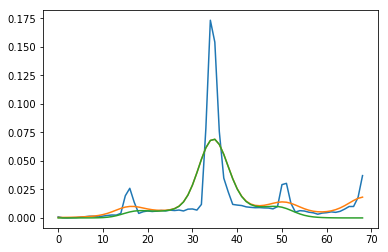

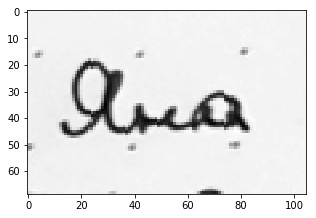

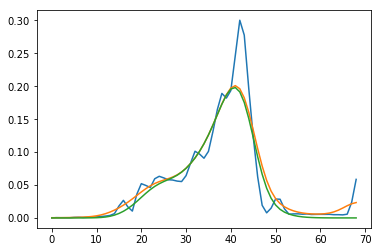

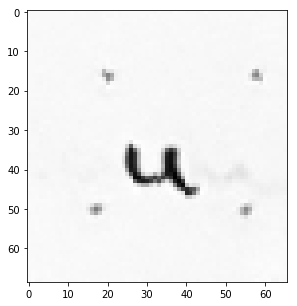

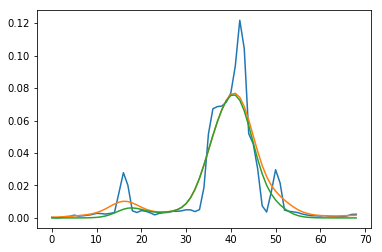

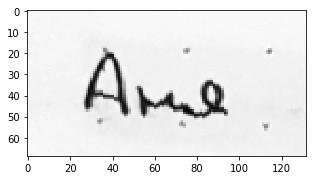

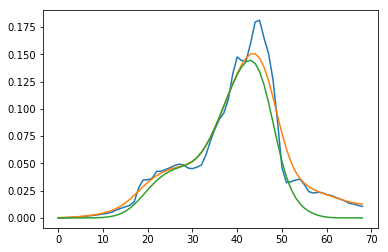

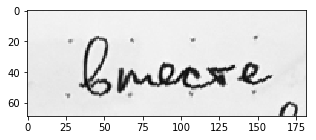

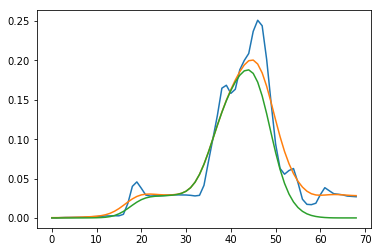

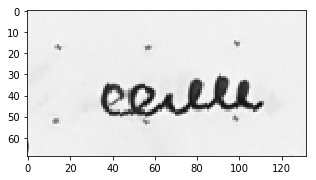

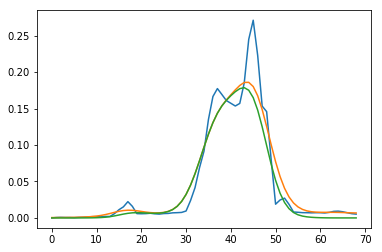

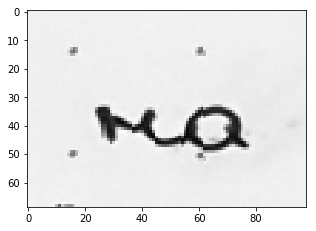

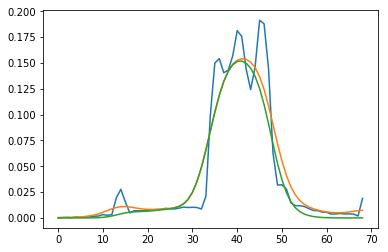

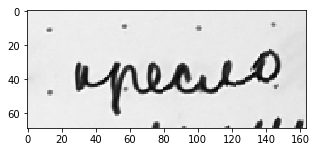

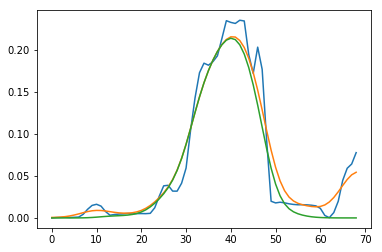

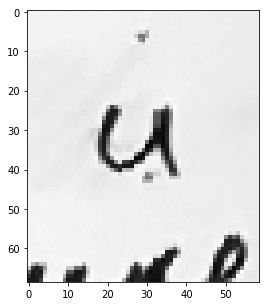

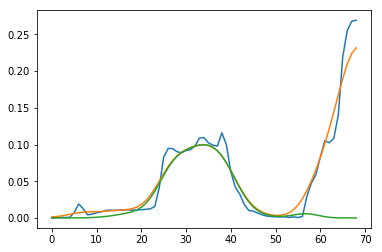

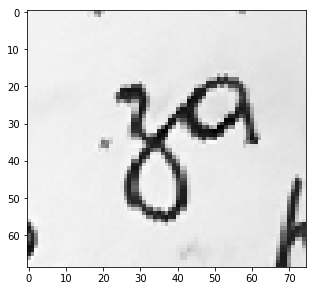

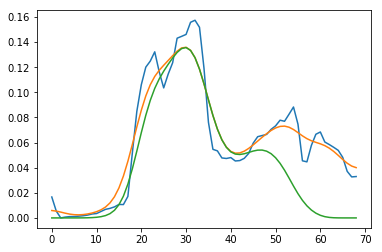

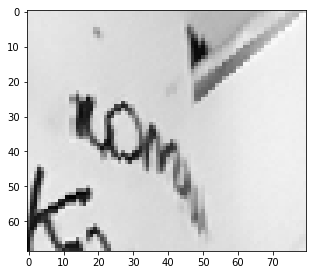

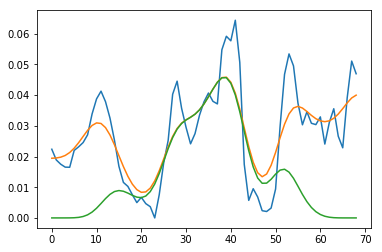

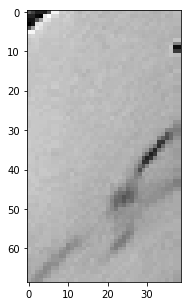

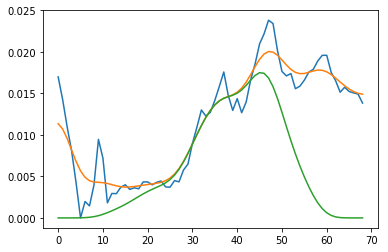

In [27]:
%%time
extracted_line = extracted_lines[0]
extracted_words = extract_words(extracted_line[0], *extracted_line[1], extracted_line[2],
                                   cutoff_coef=0.9, window=50, cutoff_ratio=0.5, cutoff_offset=0.05,
                                   sigma=(0.1, 10), filter_size=7)

plt.figure(figsize=(10,10))
plt.imshow(extracted_line[0], cmap='gray')

hgt = extracted_words[0][0].shape[0]
wreg_old  = create_regularization_vector(hgt, 2.0, 2.0, 0.5)
wreg1  = create_regularization_vector(hgt, 4.0, 4.0, 0.5)
wreg  = create_regularization_vector(hgt, 8.0, 4.0, 0.5)
plt.figure()
plt.plot(wreg)
plt.plot(wreg1)

for (wrd,_,_) in extracted_words:
    print(np.std(wrd))
    wimg = wrd #skimage.filters.gaussian(wrd, sigma=(1,5))
    plt.figure(figsize=(5,5))
    plt.imshow(wimg, cmap='gray')
    wmean = np.mean(1-wimg, axis=1)
    wmean = wmean - np.min(wmean)
    wsmth = scipy.ndimage.filters.gaussian_filter1d(wmean, 3)
    plt.figure()
    plt.plot(wmean)
    plt.plot(wsmth)
    plt.plot(wsmth * wreg)
